In [115]:
import os
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import sklearn
import librosa

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.initializers import HeNormal
from tensorflow.keras.utils import to_categorical

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix

from utils.constants import DATA_DIR, SEED

In [116]:
random.seed(SEED)
np.random.seed(SEED)
sklearn.random.seed(SEED)
tf.random.set_seed(SEED)

In [117]:
## load processed data
SEGMENT_NUM = 1

file_name = f'{SEGMENT_NUM}_data.npz'
file_path = os.path.join(DATA_DIR, 'processed_data')
npzfile = np.load(os.path.join(file_path, file_name))
print(npzfile.files)

X = npzfile['X']
Y = npzfile['Y']

['X', 'Y']


In [118]:
## Important Params
split_precentages = {
    'train': 0.7,
    'valid': 0.15,
    'test': 0.15
}

In [119]:
# TODO:
# ok - use logreg
#   - POSSIBILITY: create datapoint from each sequence elements and add label to each
# ok - use RF
# - use simple NN
# - use transformer
# - hyperparam opt and better evaluation?
# - ???

## Preprocess Data

In [120]:
## Split Data
def split_data(X, Y, split_precentages:dict):
    if sum(split_precentages.values()) != 1.0:
        raise ValueError('split precenteges together do not give 1.0!')
    
    data_size = X.shape[0]
    v_point = int(data_size * split_precentages['train'])
    t_point = v_point + int(data_size * split_precentages['valid'])

    X_train, Y_train = X[:v_point], Y[:v_point]
    X_valid, Y_valid = X[v_point:t_point], Y[v_point:t_point]
    X_test, Y_test = X[t_point:], Y[t_point:]

    return X_train, X_valid, X_test, Y_train, Y_valid, Y_test

X_train, X_valid, X_test, Y_train, Y_valid, Y_test = split_data(X, Y, split_precentages)

print('X_train shape: ', X_train.shape)
print('X_val shape: ', X_valid.shape)
print('X_test shape: ', X_test.shape)

X_train shape:  (699, 1, 37)
X_val shape:  (149, 1, 37)
X_test shape:  (151, 1, 37)


In [121]:
genres = 10
genre_list = np.unique(Y)

Y_train = to_categorical(Y_train, genres)
Y_val = to_categorical(Y_valid, genres)
Y_test = to_categorical(Y_test, genres)

## Model training
1. create model
2. train model
3. evaluate model
4. enhance model and go back to step 2.

In [122]:
from sklearn.linear_model import LogisticRegression

logreg_model = LogisticRegression(max_iter=100_000, verbose=0)
logreg_model.fit(X_train.reshape(-1,37), Y_train.argmax(axis=1))

/home/dani/miniconda3/envs/ai/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(max_iter=100000)

In [123]:
from sklearn.ensemble import RandomForestClassifier

N_ESTIMATORS = 200
MAX_DEPTH = 8

rf = RandomForestClassifier(n_estimators=N_ESTIMATORS, max_depth=MAX_DEPTH)
rf.fit(X_train.reshape(-1,37), Y_train.argmax(axis=1))

RandomForestClassifier(max_depth=8, n_estimators=200)

In [124]:
# model creation
feature_num = X_train.shape[2]
print(f'Input shape: ({SEGMENT_NUM},{feature_num})')

model = Sequential([
    LSTM(
        units=128,
        activation='relu',
        return_sequences=True,
        input_shape=(SEGMENT_NUM, feature_num)),
    BatchNormalization(),
    Dropout(0.5),
    LSTM(
        units=128,
        activation='relu',
        return_sequences=True),
    BatchNormalization(),
    Dropout(0.5),
    LSTM(
        units=64,
        activation='relu'),
    BatchNormalization(),
    Dropout(0.5),
    Dense(
        units=128,
        activation='relu',
        kernel_initializer=HeNormal,
    ),
    BatchNormalization(),
    Dropout(0.5),
    Dense(genres, activation='softmax')
])

model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy'],
)

Input shape: (1,37)


In [125]:
# callbacks
# TODO - tensorboard callback
es = EarlyStopping(
    patience=10, 
    restore_best_weights=True, 
    start_from_epoch=5)
callbacks = [es]

In [126]:
# model train
BATCH_SIZE = 32
EPOCHS = 200

history = model.fit(
    x=X_train,
    y=Y_train,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    callbacks=callbacks,
    validation_data=(X_valid,Y_val)
)

Epoch 1/200
22/22 [==============================] - 3s 22ms/step - loss: 3.4626 - accuracy: 0.0930 - val_loss: 2.3132 - val_accuracy: 0.1342
Epoch 2/200
22/22 [==============================] - 0s 5ms/step - loss: 3.2528 - accuracy: 0.1173 - val_loss: 2.3214 - val_accuracy: 0.1141
Epoch 3/200
22/22 [==============================] - 0s 5ms/step - loss: 2.9738 - accuracy: 0.1359 - val_loss: 2.3244 - val_accuracy: 0.1007
Epoch 4/200
22/22 [==============================] - 0s 5ms/step - loss: 2.8826 - accuracy: 0.1531 - val_loss: 2.3216 - val_accuracy: 0.1275
Epoch 5/200
22/22 [==============================] - 0s 5ms/step - loss: 2.8294 - accuracy: 0.1474 - val_loss: 2.3192 - val_accuracy: 0.1141
Epoch 6/200
22/22 [==============================] - 0s 6ms/step - loss: 2.7847 - accuracy: 0.1688 - val_loss: 2.3114 - val_accuracy: 0.1141
Epoch 7/200
22/22 [==============================] - 0s 6ms/step - loss: 2.7275 - accuracy: 0.1702 - val_loss: 2.3049 - val_accuracy: 0.1141
Epoch 8/200


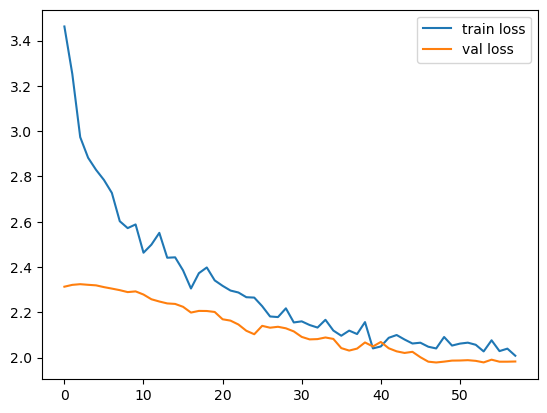

In [127]:
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.legend()
plt.show()

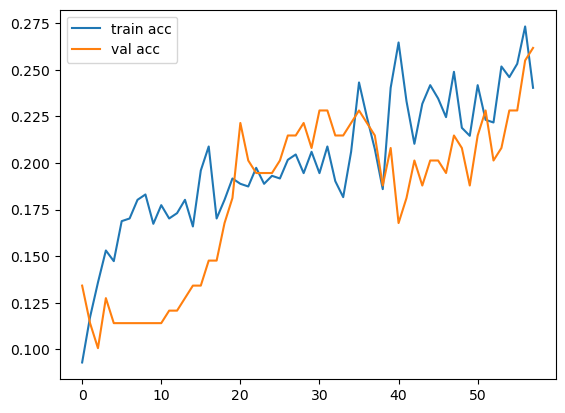

In [128]:
plt.plot(history.history['accuracy'], label='train acc')
plt.plot(history.history['val_accuracy'], label='val acc')
plt.legend()
plt.show()

## Evaluation

In [129]:
Y_true = Y_test.argmax(axis=1)

Y_pred_logreg = logreg_model.predict(X_test.reshape(-1,37))
Y_pred_rf = rf.predict(X_test.reshape(-1,37))
Y_pred_lstm = model.predict(X_test).argmax(axis=1)

5/5 [==============================] - 0s 2ms/step


In [130]:
# 1.baseline - predicting the most common class in the test set
labels, counts = np.unique(Y_true, return_counts=True)
baseline_acc = (counts.sum() / counts.max()) / 100
print(f'1.Baseline: predicting the most common label, achieved accuracy: {baseline_acc:0.2%}')

# 2.baseline - predicting randomly
print('2.Baseline: random prediction')
random_pred_num = 10
for i in range(random_pred_num):
    random_pred = np.random.randint(0, 10, size=Y_true.shape[0])
    print(f'\t{i}.accuracy: {accuracy_score(Y_true, random_pred):0.2%}')

1.Baseline: predicting the most common label, achieved accuracy: 7.95%
2.Baseline: random prediction
	0.accuracy: 7.95%
	1.accuracy: 15.23%
	2.accuracy: 9.93%
	3.accuracy: 10.60%
	4.accuracy: 9.27%
	5.accuracy: 7.95%
	6.accuracy: 9.93%
	7.accuracy: 10.60%
	8.accuracy: 11.92%
	9.accuracy: 10.60%


In [131]:
# model evaluation 
def evaluate_predictions(Y_true, Y_pred, genre_list):
    print(f'Accuracy: {accuracy_score(Y_true, Y_pred):0.2%}')
    print(f'Precision: {precision_score(Y_true, Y_pred, average="macro"):0.2%}')
    print(f'Recall: {recall_score(Y_true, Y_pred, average="macro"):0.2%}')
    print(f'F1: {f1_score(Y_true, Y_pred, average="macro")}')
    
    conf = confusion_matrix(Y_true, Y_pred)
    fig, ax = plt.subplots()
    ax.matshow(conf)
    
    ax.set_xticks(np.arange(genres), labels=genre_list)
    ax.set_yticks(np.arange(genres), labels=genre_list)
    
    for i in range(genres):
        for j in range(genres):
            text = ax.text(j, i, conf[i, j],
                           ha="center", va="center", color="w")
    
    plt.title('Confusion Matrix for Classes')
    plt.show()  

----------LOGREG----------
Accuracy: 51.66%
Precision: 47.99%
Recall: 50.48%
F1: 0.4546645488806533


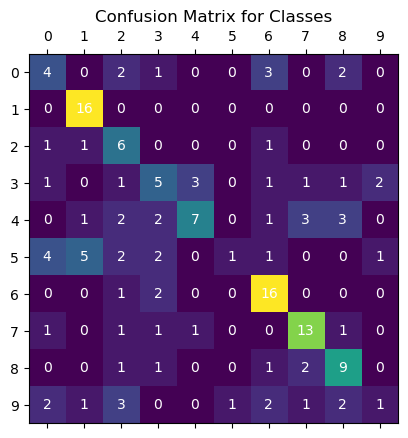

In [132]:
print('----------LOGREG----------')
evaluate_predictions(Y_true, Y_pred_logreg, genre_list)

----------RANDOM_FOREST----------
Accuracy: 70.20%
Precision: 68.53%
Recall: 68.29%
F1: 0.6770363708471125


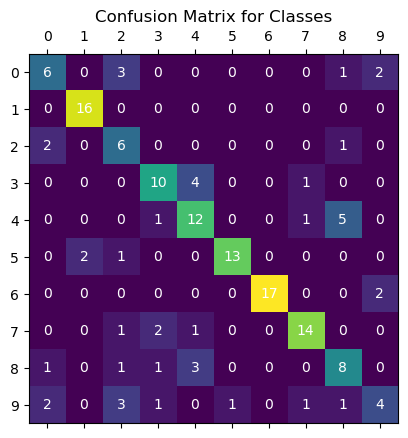

In [133]:
print('----------RANDOM_FOREST----------')
evaluate_predictions(Y_true, Y_pred_rf, genre_list)

----------LSTM----------
Accuracy: 31.13%
Precision: 21.75%
Recall: 30.63%
F1: 0.21971430552666252


/home/dani/miniconda3/envs/ai/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


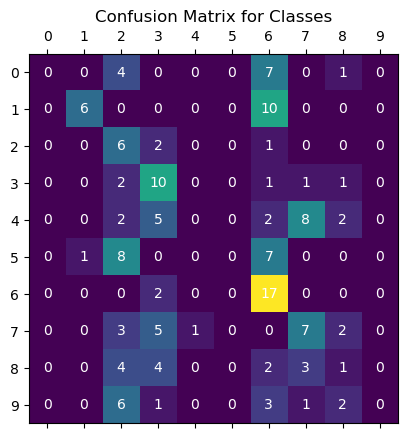

In [134]:
print('----------LSTM----------')
evaluate_predictions(Y_true, Y_pred_lstm, genre_list)